## ***Todositos***

1 - ~~Implement changes for BPA (23)~~

2 - ~~Reply to Pavel (23)~~

3 - ~~Initiate a slide for RR presentation (23)~~

4 - ~~Complete data description slide (23)~~

5 - Collect all datasets in one dataframe (23)

6 - Do EDA, gap analysis (24)

7 - Write down an email to Ł, explain the data source found and give link to notebook (24)

In [1]:
if (!requireNamespace("tidyverse", quietly = TRUE)) {install.packages("MatchIt")}
library(tidyverse)

if (!requireNamespace("dplyr", quietly = TRUE)) {install.packages("MatchIt")}
library(dplyr)

if (!requireNamespace("readxl", quietly = TRUE)) {install.packages("MatchIt")}
library(readxl)

if (!requireNamespace("reshape2", quietly = TRUE)) {install.packages("MatchIt")}
library(reshape2)

if (!requireNamespace("MatchIt", quietly = TRUE)) {install.packages("MatchIt")}
library(MatchIt)

if (!requireNamespace("lmtest", quietly = TRUE)) {install.packages("lmtest")}
library(lmtest)

if (!requireNamespace("sandwich", quietly = TRUE)) {install.packages("sandwich")}
library(sandwich)

options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 200)

Warning message:
"package 'tidyverse' was built under R version 4.3.2"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"


Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'purrr' was built under R version 4.3.2"
Warning message:
"package 'forcats' was built under R version 4.3.2"
Warning message:
"package 'lubridate' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'readxl' was built under R version 4.3.2"
Warning message:
"package 'reshape2' was built under R version 4.3.

**Processing World Bank indicators**

In [2]:
# Read indicators from World Bank
wb_indicators_raw <- read_excel("Data\\WDI - WorldBank\\Indicators.xlsx", sheet = "Data")
# Melt dataset to put years to rows
wb_indicators_melted <- melt(wb_indicators_raw, id.vars = c("Country Name", "Country Code", "Series Code", "Series Name"), 
                  variable.name = "Year", value.name = "Value")
# Convert the 'Value' column to numeric, coerce errors
wb_indicators_melted$Value <- as.numeric(as.character(wb_indicators_melted$Value))
# Clean and convert the 'Year' column to numeric
wb_indicators_melted$Year <- gsub("\\[.*\\]", "", wb_indicators_melted$Year)
wb_indicators_melted$Year <- as.numeric(wb_indicators_melted$Year)
# Drop NAs
wb_indicators_long <- na.omit(wb_indicators_melted)
# Convert to wide format, representing each indicator as a column
wb_indicators_wide <- pivot_wider(wb_indicators_long, 
                          id_cols = c("Country Name", "Country Code", "Year"),  # List the columns you want to keep as base dimensions
                          names_from = "Series Code", 
                          values_from = "Value")
# Rename columns
wb_indicators_wide <- wb_indicators_wide %>%
        rename(!!!setNames(c("Country Name", "Country Code", "Year"), c("country", "country_code", "year")))
# Column name mapping
wb_indicators_mapping <- c(
  "gdp_per_capita" = "NY.GDP.PCAP.CD",
  "gdp_per_capita_growth_pct" = "NY.GDP.PCAP.KD.ZG",
  "agriculture_pct_gdp" = "NV.AGR.TOTL.ZS",
  "industry_pct_gdp" = "NV.IND.TOTL.ZS",
  "pop_total" = "SP.POP.TOTL",
  "pop_in_largest_city_pct_of_urban_pop" = "EN.URB.LCTY.UR.ZS",
  "pop_growth_pct" = "SP.POP.GROW",
  "pop_density" = "EN.POP.DNST",
  "pop_urban" = "SP.URB.TOTL",
  "pop_urban_pct_of_total" = "SP.URB.TOTL.IN.ZS",
  "pop_rural" = "SP.RUR.TOTL",
  "pop_rural_pct_of_total" = "SP.RUR.TOTL.ZS",
  "gni" = "NY.GDY.TOTL.KN"
)
# Apply remapping of column names
wb_indicators_wide <- wb_indicators_wide %>%
  rename(!!!wb_indicators_mapping)
# Generate a binary future for negative gdp growth
wb_indicators_wide <- wb_indicators_wide %>%
  mutate(recession_binary = if_else(is.na(gdp_per_capita_growth_pct), NA_real_,
  if_else(gdp_per_capita_growth_pct < 0, 1, 0)))
# Sort dataset
wb_indicators_final <- wb_indicators_wide %>% arrange (country, year)
# Check final dataset
print(dim(wb_indicators_final))
head(wb_indicators_final)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


[1] 5232   17


country,country_code,year,gdp_per_capita,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni,recession_binary
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,AFG,2004,221.8305,-2.497255,29.72107,26.22679,23553551,53.47740,3.933178,36.11234,5299549,22.500,18254002,77.500,NA,1
Afghanistan,AFG,2005,254.1153,7.321874,31.11485,26.81210,24411191,52.42042,3.576508,37.42727,5542073,22.703,18869118,77.297,NA,0
Afghanistan,AFG,2006,274.0154,1.084988,28.63597,28.21077,25442944,51.09937,4.139678,39.00916,5828215,22.907,19614729,77.093,NA,0
Afghanistan,AFG,2007,376.3183,11.803383,30.10501,26.88224,25903301,50.99387,1.793196,39.71498,5987030,23.113,19916271,76.887,NA,0
Afghanistan,AFG,2008,382.5338,1.864754,24.89227,26.91563,26427199,50.78588,2.002333,40.51822,6162823,23.320,20264376,76.680,NA,0
Afghanistan,AFG,2009,453.3874,17.143534,29.29750,21.89712,27385307,49.79475,3.561288,41.98719,6443215,23.528,20942092,76.472,NA,0


**Processing weather variables**

In [3]:
# Read weather datasets
precipitation_raw = read_csv("Data\\Weather\\GDL-Total-Yearly-Precipitation-data.csv", col_types = cols())
humidity_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Relative-Humidity-data.csv", col_types = cols())
avg_surface_temp_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv", col_types = cols())
# Common fuction to melt and clean weather datasets
clean_weather_datasets <- function (df, measure) {
    # Melt dataset to put years to rows
    df_melted <- melt(df, id.vars = c("Country", "Continent", "ISO_Code", "Level", "GDLCODE", "Region"), 
                    variable.name = "Year", value.name = "Value")
    # Convert the 'Value' column to numeric, coerce errors
    df_melted[measure] <- as.numeric(df_melted$Value)
    # Clean and convert the 'Year' column to numeric
    df_melted$Year <- as.numeric(as.character(df_melted$Year))
    # Drop NAs
    df_final <- na.omit(df_melted)
    # Drop unnecassary columns
    cols_to_drop <- c("Continent", "Level", "GDLCODE", "Region", "Value")
    df_final <- df_final %>% select(-one_of(cols_to_drop))
    # Rename columns
    df_final <- df_final %>%
        rename(!!!setNames(c("Country", "ISO_Code", "Year"), c("country", "country_code", "year")))
    # Return cleaned dataframe
    return (df_final)
    }
# Melt and clean weather datasets
precipitation_final <- clean_weather_datasets(precipitation_raw, "precipitation")
humidity_final <- clean_weather_datasets(humidity_raw, "humidity")
avg_surface_temp_final <- clean_weather_datasets(avg_surface_temp_raw, "avg_surface_temp")
# Check dimensions before join
print(paste0("precipitation_final: " ,dim(precipitation_final)[1], " rows"))
print(paste0("humidity_final: " ,dim(humidity_final)[1], " rows"))
print(paste0("avg_surface_temp_final: " ,dim(avg_surface_temp_final)[1], " rows"))
# Inner join precipitation, humidity and avg surface temperature datasets
weather_joined <- inner_join(precipitation_final, humidity_final, by = c("country", "country_code", "year")) %>%
             inner_join(avg_surface_temp_final, by = c("country", "country_code", "year"))
# Check dimensions after inner join
print(paste0("weather_joined: " ,dim(weather_joined)[1], " rows"))
# Remap country codes to right names and remove duplication on country names
country_remap = c(
  "REU" = "Réunion", # Country was France
  "GUF" = "French Guiana", # Country was France
  "MYT" = "Mayotte", # Country was France
  "TWN" = "Taiwan", # Country was China
  "Z06" = "Unknown1", # Country was Pakistan
  "PRK" = "Unknown2" # Country was Pakistan
)
# Apply the country remap to the country column based on matches with country_code
weather_joined_mapped <- weather_joined %>%
  mutate(country = if_else(country_code %in% names(country_remap), 
                           country_remap[country_code], 
                           country))
# Sort dataset
weather_final <- weather_joined_mapped %>% arrange(country, year)
# Check dataset
print(dim(weather_final))
head(weather_final)

[1] "precipitation_final: 6666 rows"
[1] "humidity_final: 6666 rows"
[1] "avg_surface_temp_final: 6666 rows"
[1] "weather_joined: 6666 rows"
[1] 6666    6


,country,country_code,year,precipitation,humidity,avg_surface_temp
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,AFG,1990,0.016,46.92,9.466
2,Afghanistan,AFG,1991,0.021,50.84,8.369
3,Afghanistan,AFG,1992,0.019,49.57,8.203
4,Afghanistan,AFG,1993,0.014,46.11,8.754
5,Afghanistan,AFG,1994,0.017,48.90,8.812
6,Afghanistan,AFG,1995,0.016,45.20,8.728


**Processing EU ETS variables**

In [4]:
# Read EU ETS database
eu_ets_raw = read.csv("Data\\EU ETS\\ETS_Database_Jul23.csv", sep = "\t", na.strings = "", fileEncoding = "UTF-8")
# Define the mapping of old names to new names for EUAs
eua_breakdown <- c(
  "1. Total allocated allowances (EUA or EUAA)" = "total_EUAs",
  "1.1 Freely allocated allowances" = "free_EUAs",
  "1.2 Correction to freely allocated allowances (not reflected in EUTL)" = "free_correction_EUAs",
  "1.3 Allowances auctioned or sold (EUAs and EUAAs)" = "auctioned_sold_EUAs"
)
# Drop unnecassary information columns, 
# keep only total EUAs, freely allocated EUAs, correction to freely allocated EUAs and EUAs auctioned or sold
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(ETS.information %in% names(eua_breakdown)) %>%
  mutate(ETS.information = case_when(
    ETS.information %in% names(eua_breakdown) ~ eua_breakdown[ETS.information],
    TRUE ~ ETS.information
  ))
# Define the mapping of old names to new names for sector breakdown
sector_breakdown <- c(
    "20-99 All stationary installations" = "all_stationary",
    "10 Aviation" = "aviation")
# Drop sector breakdown, just include all stationary installations and aviation
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(main.activity.sector.name %in% names(sector_breakdown)) %>%
  mutate(main.activity.sector.name = case_when(
    main.activity.sector.name %in% names(sector_breakdown) ~ sector_breakdown[main.activity.sector.name],
    TRUE ~ main.activity.sector.name
  ))
# Remove period aggregates and keep years only
eu_ets_raw <- eu_ets_raw %>% filter(nchar(year) == 4)
# Convert to wide format, representing each EUA breakdown as a column
eu_ets_wide <- pivot_wider(eu_ets_raw, 
                          id_cols = c("country", "country_code", "year"),  # List the columns you want to keep as base dimensions
                          names_from = "ETS.information", 
                          values_from = "value",
                          values_fn = sum)
# Fill NAs with 0
eu_ets_wide[is.na(eu_ets_wide)] <- 0
# Convert year column to numeric
eu_ets_wide$year <- as.numeric(eu_ets_wide$year)
# Apply correction to freely allocated EUAs
eu_ets_wide$free_EUAs <- eu_ets_wide$free_EUAs + eu_ets_wide$free_correction_EUAs
# Drop correction to freely allocated EUAs column
eu_ets_wide$free_correction_EUAs <- NULL
# Rename Northen Ireland to UK
eu_ets_wide$country <- ifelse(eu_ets_wide$country %in% c("United Kingdom (excl. NI)", "Northern Ireland"), "United Kingdom", eu_ets_wide$country)
eu_ets_wide$country_code <- ifelse(eu_ets_wide$country == "United Kingdom", "UK", eu_ets_wide$country_code)
# Aggregate Northen Ireland to UK
eu_ets_final <- eu_ets_wide %>% 
  group_by(country, country_code, year) %>% 
  summarize(
    free_EUAs = sum(free_EUAs),
    total_EUAs = sum(total_EUAs),
    auctioned_sold_EUAs = sum(auctioned_sold_EUAs)
  )
# Sort dataset by country and year
eu_ets_final <- eu_ets_final %>% arrange(country, year)
# Check dataset
print(dim(eu_ets_final))
head(eu_ets_final)

`summarise()` has grouped output by 'country', 'country_code'. You can override
using the `.groups` argument.


[1] 605   6


country,country_code,year,free_EUAs,total_EUAs,auctioned_sold_EUAs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,AT,2005,32412654,32412654,0
Austria,AT,2006,32649366,32649366,0
Austria,AT,2007,32729289,32729289,0
Austria,AT,2008,30718182,30718182,0
Austria,AT,2009,30313132,30718182,405050
Austria,AT,2010,30563812,30963812,400000


**Processing PM2.5 variables**

In [5]:
# Read PM2.5 data from WHO
pm25_raw = read.csv("Data\\WHO PM2.5\\SDG Indicator 11.6.2. Concentrations of PM2.5.csv")
# Define the mapping of old names to new names for the whole dataset
pm25_columns_old <- c("SpatialDimValueCode", "Location", "Period", "Dim1", "FactValueNumeric")
pm25_columns_new <- c("country_code", "country", "year", "residence_area", "PM25")
# Drop unnecessary columns
pm25_raw <- pm25_raw %>% select(pm25_columns_old)
# Rename respective columns
pm25_raw <- pm25_raw %>% rename(!!!setNames(pm25_columns_old,pm25_columns_new))
# Convert to long format, also pulling residence area breakdown to columns
pm25_long <- pm25_raw %>%
  pivot_wider(names_from = residence_area,
              values_from = c(PM25),
              names_glue = "{.value}_{residence_area}")
# Sort dataset
pm25_final <- pm25_long %>% arrange (country,year)
# Check dataset
print(dim(pm25_final))
head(pm25_final)
# pm25_long[(pm25_long$country_code == "DEU"),]

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(pm25_columns_old)

  # Now:
  data %>% select(all_of(pm25_columns_old))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


[1] 1950    8


country_code,country,year,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,2010,92.79,61.81,68.97,69.67,83.13
AFG,Afghanistan,2011,89.57,60.11,66.94,67.72,80.45
AFG,Afghanistan,2012,92.04,61.09,68.26,68.88,82.40
AFG,Afghanistan,2013,97.49,64.50,72.18,73.01,87.33
AFG,Afghanistan,2014,91.92,60.79,68.06,68.85,82.36
AFG,Afghanistan,2015,90.88,59.99,67.20,67.90,81.38


**Combining datasets**

In [55]:
# A common function to remap country names to be consistent across data sources
map_countries <- function(df, column_to_map) {
  mapping_dict <- c(
    "Argentina urban" = "Argentina",
    "Bahamas, The" = "Bahamas",
    "Bolivia (Plurinational State of)" = "Bolivia",
    "Cape Verde" = "Cabo Verde",
    "Central African Republic CAR" = "Central African Republic",
    "Chili" = "Chile",
    "Congo Democratic Republic" = "Congo, Dem. Rep.",
    "Democratic Republic of the Congo" = "Congo, Dem. Rep.",
    "Czech Republic" = "Czechia",
    "Egypt, Arab Rep." = "Egypt",
    "Gambia, The" = "Gambia",
    "Guinea Bissau" = "Guinea-Bissau",
    "Iran (Islamic Republic of)" = "Iran",
    "Iran, Islamic Rep." = "Iran",
    "Democratic People's Republic of Korea" = "North Korea",
    "Korea, Dem. People's Rep." = "North Korea",
    "Korea, Rep." = "Korea",
    "Republic of Korea" = "Korea",
    "Kyrgyz Republic" = "Kyrgyzstan",
    "Lao People's Democratic Republic" = "Lao",
    "Lao PDR" = "Lao",
    "Micronesia (Federated States of)" = "Micronesia, Fed. Sts.",
    "Monte Negro" = "Montenegro",
    "Republic of Moldova" = "Moldova",
    "Sao Tome & Principe" = "Sao Tome and Principe",
    "Slovak Republic" = "Slovakia",
    "Syrian Arab Republic" = "Syria",
    "The former Yugoslav Republic of Macedonia" = "North Macedonia",
    "Timor-Leste" = "Timor Leste",
    "Trinidad & Tobago" = "Trinidad and Tobago",
    "Türkiye" = "Turkey",
    "Turkiye" = "Turkey",
    "United States of America" = "United States",
    "Venezuela (Bolivarian Republic of)" = "Venezuela",
    "Venezuela, RB"  = "Venezuela",
    "Viet Nam" = "Vietnam",
    "Yemen, Rep." = "Yemen",
    "United Kingdom of Great Britain and Northern Ireland" = "United Kingdom"
  )
  
  df[[column_to_map]] <- ifelse(df[[column_to_map]] %in% names(mapping_dict), 
                                mapping_dict[df[[column_to_map]]], 
                                df[[column_to_map]])
  
  return(df)
}

# Map country names in each dataset
pm25_final_mapped <- map_countries(pm25_final, "country")
eu_ets_final_mapped <- map_countries(eu_ets_final, "country")
weather_final_mapped <- map_countries(weather_final, "country")
wb_indicators_final_mapped <- map_countries(wb_indicators_final, "country")

# Join each dataset, keeping PM2.5 dataset as the main one to join on
all_indicators <- merge(pm25_final_mapped, subset(eu_ets_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(weather_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(wb_indicators_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE)

# Apply log transformation for skewed columns
all_indicators <- all_indicators %>%
  mutate_at(vars(PM25_Cities, PM25_rural, PM25_Total, PM25_Towns, PM25_Urban,
                 gdp_per_capita, pop_total, pop_density, free_EUAs, total_EUAs, auctioned_sold_EUAs), 
             list(log = ~log(.)))

# Drop the original columns
all_indicators <- all_indicators %>%
  select(-PM25_Cities, -PM25_rural, -PM25_Total, -PM25_Towns, -PM25_Urban,
         -gdp_per_capita, -pop_total, -pop_density, -free_EUAs, -total_EUAs, -auctioned_sold_EUAs)

# Find the quantiles for trimming
lower_quantile <- quantile(all_indicators$gdp_per_capita_growth_pct, probs = 0.005, na.rm = TRUE)
upper_quantile <- quantile(all_indicators$gdp_per_capita_growth_pct, probs = 0.995, na.rm = TRUE)

# Trim the values and assign NAs
all_indicators$gdp_per_capita_growth_pct[all_indicators$gdp_per_capita_growth_pct < lower_quantile | 
                                          all_indicators$gdp_per_capita_growth_pct > upper_quantile] <- NA

# Drop unnecassary indicators (for now)
all_indicators <- all_indicators %>% select(-c(gni,pop_rural,pop_urban,total_EUAs_log))

# Check final dataset
print(dim(all_indicators))
head(all_indicators)

[1] 1950   24


,year,country,country_code,precipitation,humidity,avg_surface_temp,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_in_largest_city_pct_of_urban_pop,⋯,PM25_Cities_log,PM25_rural_log,PM25_Total_log,PM25_Towns_log,PM25_Urban_log,gdp_per_capita_log,pop_total_log,pop_density_log,free_EUAs_log,auctioned_sold_EUAs_log
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,Afghanistan,AFG,0.015,43.45,10.590,11.0992199,26.2100685,21.15142,49.15285,⋯,4.530339,4.124065,4.233672,4.243770,4.420406,6.332390,17.15447,3.766314,NA,NA
2,2010,Albania,ALB,0.063,72.59,13.010,4.2230838,17.9558664,24.93746,26.89647,⋯,3.101892,3.062456,3.088767,3.107721,3.104587,8.317363,14.88470,4.666403,NA,NA
3,2010,Algeria,DZA,0.012,50.79,18.910,1.6921701,8.4664436,49.96743,10.04247,⋯,3.075929,3.078233,3.057298,3.010128,3.045474,8.410926,17.39503,2.711689,NA,NA
4,2010,Andorra,AND,0.033,72.37,4.326,1.2226877,0.4665086,13.12565,NA,⋯,NA,2.354228,2.436241,2.474856,2.474856,10.783900,11.17772,5.024986,NA,NA
5,2010,Angola,AGO,0.037,63.60,22.770,0.5712209,6.1802935,52.36844,37.94772,⋯,3.303217,3.160823,3.186353,3.191710,3.278276,8.184978,16.96671,2.930704,NA,NA
6,2010,Antigua and Barbuda,ATG,0.042,78.98,26.770,-9.0891748,1.6334085,16.20415,NA,⋯,NA,2.078191,2.100469,2.115050,2.115050,9.503347,11.35855,5.271775,NA,NA


### EDA

In [56]:
head(all_indicators)

,year,country,country_code,precipitation,humidity,avg_surface_temp,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_in_largest_city_pct_of_urban_pop,⋯,PM25_Cities_log,PM25_rural_log,PM25_Total_log,PM25_Towns_log,PM25_Urban_log,gdp_per_capita_log,pop_total_log,pop_density_log,free_EUAs_log,auctioned_sold_EUAs_log
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,Afghanistan,AFG,0.015,43.45,10.590,11.0992199,26.2100685,21.15142,49.15285,⋯,4.530339,4.124065,4.233672,4.243770,4.420406,6.332390,17.15447,3.766314,NA,NA
2,2010,Albania,ALB,0.063,72.59,13.010,4.2230838,17.9558664,24.93746,26.89647,⋯,3.101892,3.062456,3.088767,3.107721,3.104587,8.317363,14.88470,4.666403,NA,NA
3,2010,Algeria,DZA,0.012,50.79,18.910,1.6921701,8.4664436,49.96743,10.04247,⋯,3.075929,3.078233,3.057298,3.010128,3.045474,8.410926,17.39503,2.711689,NA,NA
4,2010,Andorra,AND,0.033,72.37,4.326,1.2226877,0.4665086,13.12565,NA,⋯,NA,2.354228,2.436241,2.474856,2.474856,10.783900,11.17772,5.024986,NA,NA
5,2010,Angola,AGO,0.037,63.60,22.770,0.5712209,6.1802935,52.36844,37.94772,⋯,3.303217,3.160823,3.186353,3.191710,3.278276,8.184978,16.96671,2.930704,NA,NA
6,2010,Antigua and Barbuda,ATG,0.042,78.98,26.770,-9.0891748,1.6334085,16.20415,NA,⋯,NA,2.078191,2.100469,2.115050,2.115050,9.503347,11.35855,5.271775,NA,NA


In [62]:
column_order <- c('PM25_Cities_log', 'PM25_rural_log', 'PM25_Total_log', 'PM25_Towns_log', 'PM25_Urban_log',
'precipitation', 'humidity', 'avg_surface_temp', 
'gdp_per_capita_log', 'gdp_per_capita_growth_pct', 'recession_binary', 'agriculture_pct_gdp', 'industry_pct_gdp', 
'pop_total_log', 'pop_density_log', 'pop_growth_pct', 'pop_urban_pct_of_total', 'pop_rural_pct_of_total', 'pop_in_largest_city_pct_of_urban_pop',
'free_EUAs_log', 'auctioned_sold_EUAs_log')

all_indicators <- all_indicators %>% select(all_of(c("country", "year", "country_code", column_order)))

all_indicators$dummyvar <- "dummyvar"  # Create a dummy variable for pivot_longer()
# dummyvar<- "dummyvar"
# Reshape the dataframe to long format
selected_variables_long <- pivot_longer(all_indicators[,setdiff(colnames(all_indicators), c("year", "country", "country_code", "recession_binary"))], -dummyvar)
all_indicators$dummyvar <- NULL

# Convert 'name' to factor with levels based on original dataset order
selected_variables_long$name <- factor(selected_variables_long$name, levels = names(all_indicators)[!names(all_indicators) %in% c("year", "country", "country_code", "recession_binary")])

# Create the plot with KDE and CDF
plot_vars <- ggplot(selected_variables_long, aes(x = value, y = ..density..)) +
  geom_histogram(bins = 20, fill = "lightblue", color = "black", na.rm = TRUE) +
  geom_density(color = "darkred", adjust = 1, na.rm = TRUE) +  # Adjust the bandwidth
  facet_wrap(~name, scales = "free") +
  theme_minimal() +  # Adjust the theme if needed
  labs(title = "Distribution of Variables",
       x = "Value",
       y = "Frequency")

plot(plot_vars)

# Save the plot with adjusted width
# ggsave("plot_vars.jpg", plot_vars, width = 15, height = 8)


In [75]:
# Calculate the number of non-NA values for each column
non_na_counts <- all_indicators %>%
  select(-c(country,country_code)) %>%
  group_by(year) %>%
  summarize(across(everything(), ~sum(!is.na(.))))

# Reshape the data for plotting while retaining column order
non_na_counts_long <- non_na_counts %>%
  pivot_longer(cols = -year, names_to = "variable", values_to = "count") %>%
  mutate(variable = factor(variable, levels = colnames(non_na_counts)[-1]))  # Exclude the "year" column from levels

non_na_counts_long$variable <- factor(non_na_counts_long$variable, levels = 
  names(all_indicators)[!names(all_indicators) %in% c("year", "country", "country_code")])

# Create the heatmap
heatmap_plot <- ggplot(data = non_na_counts_long, aes(x = year, y = variable, fill = count)) +
  geom_tile() +
  scale_fill_distiller() +  # Choose color palette
  geom_text(aes(label = ifelse(is.na(count), "", count)), size = 4, color = "black") +  # Add text labels with small font
  scale_x_continuous(breaks = seq(min(non_na_counts_long$year), max(non_na_counts_long$year), by = 1)) +  # Display integer values on X-axis
  labs(title = "Number of Countries with Respective Metric & Year",
       x = "Year",
       y = "Variable",
       fill = "Count") +
  theme_minimal()
# Display the heatmap
print(heatmap_plot)

**Matching**

,year,country,country_code,precipitation_log,humidity_log,avg_surface_temp_log,gdp_per_capita_log,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,⋯,population_density_log,population_urban_log,population_urban_pct_of_total,population_rural_log,population_rural_pct_of_total,gni_log,total_EUAs,PM25_Total,PM25_Urban,PM25_rural
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,Afghanistan,AFG,-3.688879,3.771611,2.415824,6.332390,11.0992199,26.2100685,21.15142,⋯,3.766314,15.71633,23.737,16.883484,76.263,NA,NA,68.97,83.13,61.81
2,2010,Albania,ALB,-2.617296,4.284827,2.611466,8.317363,4.2230838,17.9558664,24.93746,⋯,4.666403,14.23390,52.163,14.147331,47.837,27.84585,NA,21.95,22.30,21.38
3,2010,Algeria,DZA,-3.816713,3.927699,2.971388,8.410926,1.6921701,8.4664436,49.96743,⋯,2.711689,17.00258,67.540,16.269869,32.460,30.27401,NA,21.27,21.02,21.72
4,2010,Andorra,AND,-3.146555,4.281792,1.596353,10.783900,1.2226877,0.4665086,13.12565,⋯,5.024986,11.05914,88.819,8.986823,11.181,NA,NA,11.43,11.88,10.53
5,2010,Angola,AGO,-3.057608,4.152613,3.151838,8.184978,0.5712209,6.1802935,52.36844,⋯,2.930704,16.45227,59.783,16.055834,40.217,27.89087,NA,24.20,26.53,23.59
6,2010,Antigua and Barbuda,ATG,-2.956512,4.369195,3.309776,9.503347,-9.0891748,1.6334085,16.20415,⋯,5.271775,10.02060,26.238,11.054218,73.762,NA,NA,8.17,8.29,7.99


In [ ]:
unique(selected_variables_long$name)

[1] "precipitation_log"                          
 [2] "humidity_log"                               
 [3] "avg_surface_temp_log"                       
 [4] "gdp_per_capita_log"                         
 [5] "gdp_per_capita_growth_pct"                  
 [6] "agriculture_pct_gdp"                        
 [7] "industry_pct_gdp"                           
 [8] "population_log"                             
 [9] "population_in_largest_city_pct_of_urban_pop"
[10] "population_growth_pct"                      
[11] "population_density_log"                     
[12] "population_urban_log"                       
[13] "population_urban_pct_of_total"              
[14] "population_rural_log"                       
[15] "population_rural_pct_of_total"              
[16] "gni_log"                                    
[17] "total_EUAs"                                 
[18] "PM25_Total"                                 
[19] "PM25_Urban"                                 
[20] "PM25_rural"

In [39]:
library(ggplot2)
library(tidyr)

# # Define the variables to plot
# var_to_plot <- c("precipitation_log", "humidity_log", "avg_surface_temp_log", 
#                  "gdp_per_capita_log", "gdp_per_capita_growth_pct", 
#                  "agriculture_pct_gdp", "industry_pct_gdp", 
#                  "population_log", "population_in_largest_city_pct_of_urban_pop",
#                  "population_growth_pct", "population_density_log", 
#                  "population_urban_log", "population_urban_pct_of_total", 
#                  "population_rural_log", "population_rural_pct_of_total", 
#                  "gni_log", "PM25_Total", "PM25_Urban", "PM25_rural")

all_indicators_renamed$dummyvar <- "dummyvar"  # Create a dummy variable for pivot_longer()
dummyvar<- "dummyvar"
# Reshape the dataframe to long format
selected_variables_long <- pivot_longer(all_indicators_renamed[, c(setdiff(colnames(all_indicators_renamed), c("year", "country", "country_code")))], -dummyvar)

# Create the plot
# Create the plot with KDE and CDF
plot <- ggplot(selected_variables_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "lightblue", color = "black") +
  geom_density(color = "red") +  # Add KDE lines
  facet_wrap(~name, scales = "free") +
  theme_minimal() +  # Adjust the theme if needed
  labs(title = "Distribution of Selected Variables",
       x = "Value",
       y = "Density")

print(plot)

# Save the plot with adjusted width
ggsave("plot.jpg", plot, width = 15, height = 8)


ERROR: Error: object 'all_indicators_renamed' not found


![Plot](plot.jpg)

In [38]:
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 300)

In [ ]:
![Plot](plot.jpg)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:2: unexpected '['
1: ![
     ^


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.



Call:
matchit(formula = is_eu_ets ~ precipitation_log + humidity_log + 
    avg_surface_temp_log + gdp_per_capita_log + gdp_per_capita_growth_pct + 
    agriculture_pct_gdp + industry_pct_gdp + population_log + 
    population_in_largest_city_pct_of_urban_pop + population_growth_pct + 
    population_density_log + population_urban_log + population_urban_pct_of_total + 
    population_rural_log + population_rural_pct_of_total + gni_log, 
    data = all_indicators_renamed, method = "nearest", distance = "glm", 
    exact = "year", replace = FALSE, ratio = 1)

Summary of Balance for All Data:
                                            Means Treated Means Control
distance                                           0.7072        0.0515
precipitation_log                                 -3.1501       -2.8298
humidity_log                                       4.1710        3.7708
avg_surface_temp_log                               2.2202        2.7031
gdp_per_capita_log                        

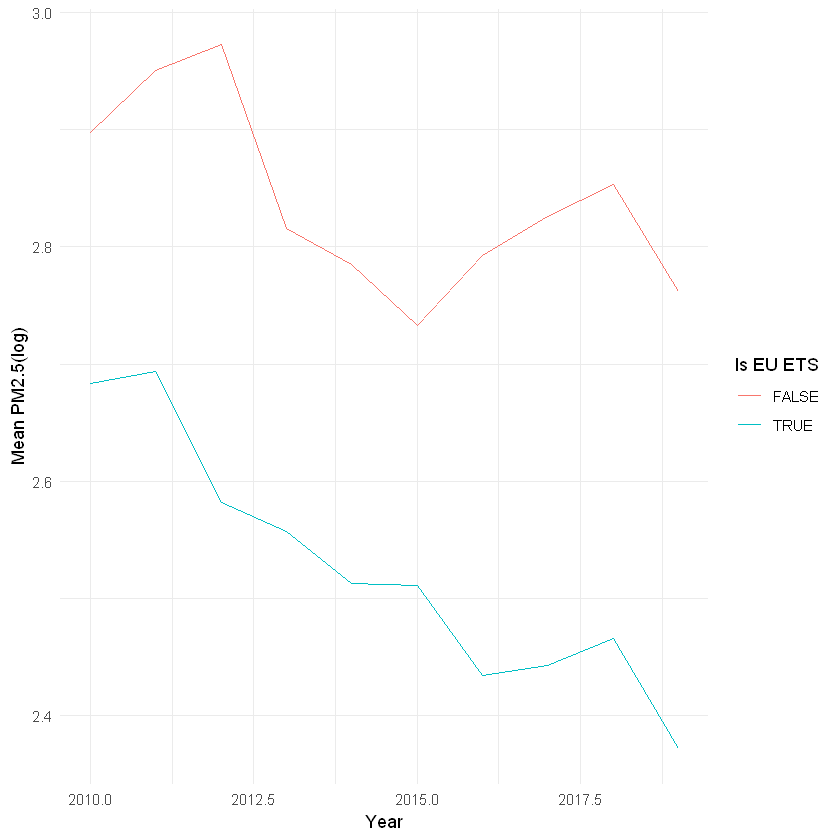

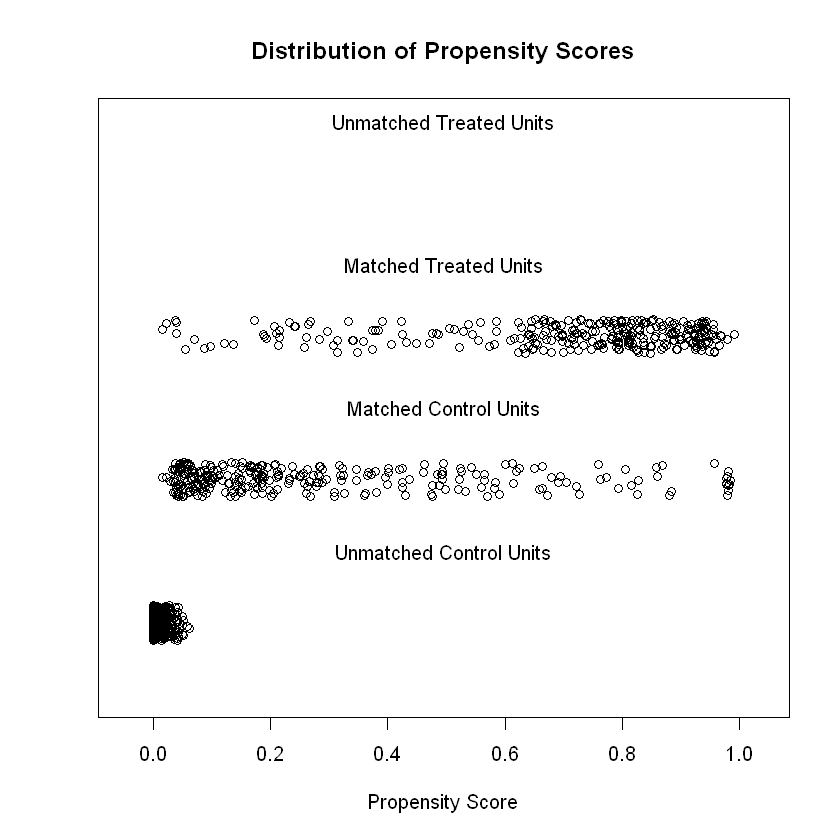

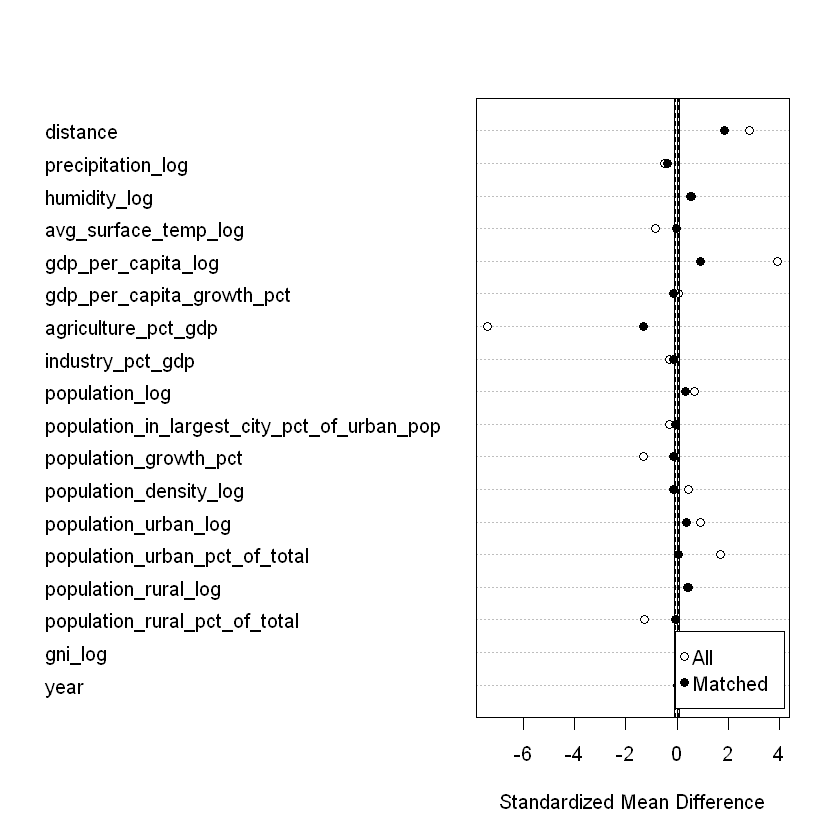

In [ ]:
#Using the mathcit function from MatchIt to match each smoker with a non-smoker (1 to 1 matching) based on
#sex, indigeneity status, high school completion, marital status (partnered or not),
#region of residence (major cities, inner regional, outer regional), language background (English speaking Yes/No) 
#and risky alcohol drinking (Yes/No)

all_indicators_renamed$total_EUAs <- ifelse(is.na(all_indicators_renamed$total_EUAs),0,all_indicators$total_EUAs)

all_indicators_renamed$is_eu_ets <- ifelse(all_indicators_renamed$total_EUAs>0,TRUE,FALSE)

all_indicators_renamed[is.na(all_indicators_renamed)] <- 0

match_obj <- matchit(is_eu_ets ~ 
                      precipitation_log 
                      + humidity_log
                      + avg_surface_temp_log 
                      + gdp_per_capita_log 
                      + gdp_per_capita_growth_pct 
                      + agriculture_pct_gdp
                      + industry_pct_gdp 
                      + population_log 
                      + population_in_largest_city_pct_of_urban_pop 
                      + population_growth_pct
                      + population_density_log 
                      + population_urban_log 
                      + population_urban_pct_of_total 
                      + population_rural_log
                      + population_rural_pct_of_total
                      + gni_log
  ,data = all_indicators_renamed, method = "nearest"
  , distance ="glm"
  ,ratio = 1
  ,replace = FALSE
  ,exact = "year")

matched_subset <-match.data(match_obj)

summary_df <- matched_subset %>%
  group_by(year, is_eu_ets) %>%
  summarise(mean_pm25 = mean(log(PM25_Total)))

# Plotting
ggplot(summary_df, aes(x = year, y = mean_pm25, color = as.factor(is_eu_ets))) +
  geom_line() +
  labs(x = "Year", y = "Mean PM2.5(log)", color = "Is EU ETS") +
  theme_minimal()

summary(match_obj)
#plotting the balance between smokers and non-smokers
plot(match_obj, type = "jitter", interactive = FALSE)
plot(summary(match_obj), abs = FALSE)

In [ ]:
unique(matched_subset[matched_subset$is_eu_ets == FALSE,"country"])

[1] "Andorra"                "Armenia"                "Bahamas"               
 [4] "Bahrain"                "Bosnia and Herzegovina" "Cabo Verde"            
 [7] "Canada"                 "Croatia"                "Georgia"               
[10] "Iceland"                "Israel"                 "Jamaica"               
[13] "Japan"                  "Korea"                  "Lebanon"               
[16] "Mauritius"              "Montenegro"             "New Zealand"           
[19] "North Macedonia"        "Russian Federation"     "San Marino"            
[22] "Serbia"                 "Seychelles"             "South Africa"          
[25] "Switzerland"            "Ukraine"                "United States"         
[28] "United Arab Emirates"   "Costa Rica"             "Kazakhstan"            
[31] "Libya"                  "Mongolia"               "Turkey"                
[34] "Australia"              "Belarus"                "Brunei Darussalam"     
[37] "Cuba"                   "Syria"                  "Marshall Islands"      
[40] "Monaco"                 "Mexico"

In [ ]:
head(matched_subset)

,year,country,country_code,precipitation_log,humidity_log,avg_surface_temp_log,gdp_per_capita_log,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,⋯,population_rural_pct_of_total,gni_log,total_EUAs,PM25_Total,PM25_Urban,PM25_rural,is_eu_ets,distance,weights,subclass
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<fct>
4,2010,Andorra,AND,-3.146555,4.281792,1.596353,10.783900,1.2226877,0.4665086,13.12565,⋯,11.181,0.00000,0,11.43,11.88,10.53,FALSE,0.95743561,1,243
8,2010,Armenia,ARM,-3.270169,4.182813,2.284828,8.052942,2.8244819,0.0000000,0.00000,⋯,36.560,28.97109,0,40.90,43.43,34.11,FALSE,0.70463539,1,1
10,2010,Austria,AUT,-2.937463,4.342116,1.934127,10.755853,1.5925771,1.2673277,25.53499,⋯,42.601,26.51003,30963812,15.62,16.97,13.97,TRUE,0.95583165,1,1
12,2010,Bahamas,BHS,-3.170086,4.304741,3.236676,10.205319,0.1200612,1.0974904,11.49988,⋯,17.573,23.22006,0,4.97,4.98,4.94,FALSE,0.38059116,1,151
13,2010,Bahrain,BHR,-4.605170,4.228293,3.315966,9.961134,1.3948907,0.2976772,44.97595,⋯,11.366,22.99211,0,55.87,55.92,54.97,FALSE,0.04732183,1,123
17,2010,Belgium,BEL,-3.218876,4.358374,2.268511,10.696139,1.9287642,0.7651042,20.89458,⋯,2.349,26.68913,56025477,16.08,16.54,14.07,TRUE,0.29789642,1,123


In [ ]:
matched_subset[(matched_subset$subclass %in% matched_subset[matched_subset$country == "France","subclass"]),] %>% arrange (year,country)

year,country,country_code,precipitation_log,humidity_log,avg_surface_temp_log,gdp_per_capita_log,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,⋯,population_rural_pct_of_total,gni_log,total_EUAs,PM25_Total,PM25_Urban,PM25_rural,is_eu_ets,distance,weights,subclass
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<fct>
2010,France,FRA,-3.170086,4.309322,2.394161,10.613395,1.44824526,1.6040283,17.84574,⋯,21.631,28.36023,133235375,14.45,15.83,12.06,TRUE,0.8495435,1,233
2010,Lebanon,LBN,-3.729701,4.093511,2.925793,8.948358,7.00978278,3.8619594,13.80938,⋯,12.666,31.69067,0,24.24,24.42,22.41,FALSE,0.1721411,1,233
2011,Bahamas,BHS,-3.194183,4.334542,3.256133,10.190354,-0.63214852,1.0923047,12.04514,⋯,17.524,23.20814,0,4.92,4.92,4.92,FALSE,0.4007486,1,175
2011,France,FRA,-3.324236,4.296605,2.544668,10.688449,1.70061040,1.6502872,17.97817,⋯,21.378,28.37510,134068129,14.72,16.12,12.31,TRUE,0.8566765,1,175
2012,France,FRA,-3.170086,4.307707,2.473087,10.618172,-0.17116134,1.6317950,17.86855,⋯,21.122,28.37701,147518340,13.29,14.53,11.15,TRUE,0.8283580,1,204
2012,Seychelles,SYC,0.000000,0.000000,0.000000,9.420805,2.10412827,1.9989852,19.72582,⋯,45.880,23.56113,0,17.82,18.33,17.10,FALSE,0.2124462,1,204
2013,France,FRA,-3.123566,4.327438,2.437029,10.659673,0.05814951,1.4586322,17.97180,⋯,20.865,28.38572,140963719,12.95,14.15,10.91,TRUE,0.8379536,1,240
2013,Serbia,SRB,-3.381395,4.247209,2.542310,8.818049,3.39452352,7.4142164,26.83981,⋯,44.531,29.09116,0,26.17,26.90,25.12,FALSE,0.2095791,1,240
2014,Cabo Verde,CPV,-4.268698,4.367040,3.145832,8.226648,-0.43481440,5.7350692,15.45570,⋯,36.190,25.86718,0,30.11,31.57,26.50,FALSE,0.2082906,1,275


In [ ]:
  # Select unique combinations of "country" and "country_code" from pm25_final
  pm25_unique <- pm25_final_mapped %>%
    select(country) %>%
    unique()

  pm25_unique$pm <- 1

  # Select unique combinations of "country" and "country_code" from eu_ets_final
  eu_ets_unique <- eu_ets_final_mapped %>%
    select(country) %>%
    unique()

  eu_ets_unique$euets <- 1

  # Select unique combinations of "country" and "country_code" from weather_final
  weather_unique <- weather_final_mapped %>%
    select(country) %>%
    unique()

  weather_unique$weather <- 1

  # Select unique combinations of "country" and "country_code" from wb_indicators_final
  wb_indicators_unique <- wb_indicators_final_mapped %>%
    select(country) %>%
    unique()

  wb_indicators_unique$wb <- 1

# Union the datasets
unioned_dimensions <- bind_rows(pm25_unique, eu_ets_unique, weather_unique, wb_indicators_unique)

# Add origin indicators to each dataset
pm25_unique$pm <- 1
eu_ets_unique$euets <- 1
weather_unique$weather <- 1
wb_indicators_unique$wb <- 1

# Perform full joins
joined_df <- full_join(pm25_unique, eu_ets_unique, by = "country") %>%
             full_join(weather_unique, by = "country") %>%
             full_join(wb_indicators_unique, by = "country")

joined_df[is.na(joined_df)] <- 0

joined_df$total = joined_df$pm + joined_df$euets + joined_df$weather + joined_df$wb

joined_df <- joined_df %>% arrange (pm, total)

joined_df[joined_df$total < 3,]


Adding missing grouping variables: `country_code`


ERROR: [1m[33mError[39m in `[<-`:[22m
[1m[22m[33m![39m Assigned data `0` must be compatible with existing data.
[36mℹ[39m Error occurred for column `country_code`.
[1mCaused by error in `vec_assign()`:[22m
[33m![39m Can't convert <double> to <character>.
